#  Graph attention networks (GAT) implementation
- https://www.youtube.com/watch?v=A-yKQamf2Fc [Understanding Graph Attention Networks]
- https://www.youtube.com/watch?v=CwsPoa7z2c8 [Pytorch Geometric tutorial: Graph attention networks (GAT) implementation]
- https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial3/Tutorial3.ipynb
- https://github.com/rish-16/pytorch-graphdl/blob/main/gat/layers.py
- https://github.com/rish-16/gin-attn-conv-pytorch/blob/main/gin_attn_pytorch/gin_attn_conv.py
- https://arxiv.org/abs/1710.10903

In [139]:
import torch
from torch import nn as tnn 
from torch_geometric import nn as gnn
from torch_geometric.utils import add_self_loops, degree, softmax
from torch_scatter import scatter
from torch_geometric.data import Data
from loguru import logger

In [9]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [8]:
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())
data

Data(x=[3, 1], edge_index=[2, 4])

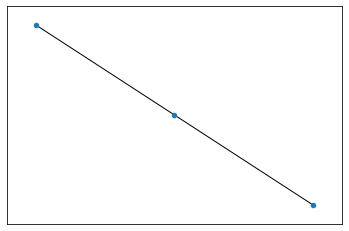

In [12]:
edges = edge_index.numpy()

G = nx.Graph()
G.add_edges_from(edges)
nx.draw_networkx(G, with_labels=False, node_size=20)

## Dummy GAT Layer
- Was possible due to following resources
    - https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/gat_conv.html#GATConv

In [216]:
class DummyGATLayer(gnn.MessagePassing):
    def __init__(self, in_channels=2, out_channels=4):
        super().__init__(aggr='add')
        
        self.linear1 = tnn.Linear(in_features=in_channels, out_features=out_channels)
        self.attn_linear = tnn.Linear(in_features=2*out_channels, out_features=1)
        
        self.leaky_relu = tnn.LeakyReLU(negative_slope=0.2)
        
    def forward(self, x , edge_index, edge_attrs=None):
        
        edge_index, _  = add_self_loops(edge_index, num_nodes=x.shape[0])
        h = self.linear1(x)
        logger.info(f"|after linear layer {h.shape}|") 

        out = self.propagate(edge_index, x=x, h=h)
        # the propagate calls 
           # - message
           # - aggregate
           # - update
        return out
    
    def message(self, h_i, h_j, edge_index, index):
        
#         src_node_idx, dst_node_idx = edge_index
#         logger.info(src_node_idx)
#         logger.info(dst_node_idx)

#         logger.info(x_i.shape)
#         logger.info(x_j.shape)
        logger.info("*"*50)
        logger.info(h_i.shape)
        logger.info(h_j.shape)
        
        # Here we Concat the src node embeds and dst node embeds/features
        cat = torch.cat([h_i, h_j], dim=1) # [7, 4]
        
        logger.info("Concat" + "*"*50)
        logger.info(cat.shape)
#         logger.info(cat)
        
#         now need to pass this concat feature to the feed-forward layer to get attention score
        e_j = self.attn_linear(cat)   # [7, 1]
        logger.info("e_J" + "*"*50)
        logger.info(e_j)
        logger.info(e_j.shape) 
        
        logger.info(f"Node index passed {index}") # dst node idx
        alphas = softmax(self.leaky_relu(e_j), index=index) # performs softmax with the neighbouring nodes.
        logger.info(alphas.shape)
        logger.info(f"Attention coefficient are : {alphas}")
        # lets check if the sum is 1 or not for each nodes
        sum_of_node_attn_score = scatter(alphas, index, dim=0, reduce='sum')
        logger.info(f"Sum are : {sum_of_node_attn_score}")
        logger.info("*"*50)
       
            
        msg = alphas * h_j
        logger.info(msg.shape)
        logger.info(msg)
        logger.info("*"*50)

        return msg
        
    def update(self, aggr_out, x):
        logger.info(x)
        logger.info(aggr_out)
        return aggr_out

# class DummyGATLayer(gnn.MessagePassing):
#     def __init__(self, in_channels=1, out_channels=2):
#         super().__init__(aggr='add')
        
#         self.linear1 = tnn.Linear(in_features=in_channels, out_features=out_channels)
#         self.attn_linear = tnn.Linear(in_features=2*out_channels, out_features=1)
        
#         self.leaky_relu = tnn.LeakyReLU(negative_slope=0.2)
        
#     def forward(self, x , edge_index, edge_attrs=None):
        
#         edge_index, _  = add_self_loops(edge_index, num_nodes=x.shape[0])
#         h = self.linear1(x)
#         out = self.propagate(edge_index, x=x, h=h)
#         return out
    
#     def message(self, h_i, h_j, edge_index, index):
                
#         # Here we Concat the src node embeds and dst node embeds/features
#         cat = torch.cat([h_i, h_j], dim=1) # [num_nodes, 2 * out_channels]
               
#         # now need to pass this concat feature to the feed-forward layer to get attention score
#         e_j = self.attn_linear(cat) # [num_nodes, 1]
#         alphas = softmax(self.leaky_relu(e_j), index=index) # performs softmax with the neighboring nodes.       
            
#         msg = alphas * h_j

#         return msg

In [217]:
torch.manual_seed(42)
dummy_gat = DummyGATLayer(in_channels=1, out_channels=2)

In [218]:
dummy_gat(data.x, data.edge_index)

2022-03-08 01:19:37.609 | INFO     | __main__:forward:14 - |after linear layer torch.Size([3, 2])|
2022-03-08 01:19:37.611 | INFO     | __main__:message:31 - **************************************************
2022-03-08 01:19:37.611 | INFO     | __main__:message:32 - torch.Size([7, 2])
2022-03-08 01:19:37.612 | INFO     | __main__:message:33 - torch.Size([7, 2])
2022-03-08 01:19:37.612 | INFO     | __main__:message:38 - Concat**************************************************
2022-03-08 01:19:37.613 | INFO     | __main__:message:39 - torch.Size([7, 4])
2022-03-08 01:19:37.614 | INFO     | __main__:message:44 - e_J**************************************************
2022-03-08 01:19:37.614 | INFO     | __main__:message:45 - tensor([[0.8283],
        [0.8859],
        [0.8859],
        [0.9435],
        [0.8283],
        [0.8859],
        [0.9435]], grad_fn=<AddmmBackward>)
2022-03-08 01:19:37.616 | INFO     | __main__:message:46 - torch.Size([7, 1])
2022-03-08 01:19:37.618 | INFO     | __

tensor([[-0.6055,  0.5156],
        [-0.2049,  0.9505],
        [ 0.1590,  1.3456]], grad_fn=<ScatterAddBackward>)

In [215]:
torch.manual_seed(42)


gat_pyg = gnn.GATConv(1, 2)

print(gat_pyg(data.x, data.edge_index))

dummy_gat = DummyGATLayer(in_channels=1, out_channels=2)
dummy_gat(data.x, data.edge_index)

tensor([[ 0.1206, -0.1111],
        [-0.0583,  0.0537],
        [-0.1619,  0.1491]], grad_fn=<AsStridedBackward>)


tensor([[0.3252, 0.0464],
        [0.9134, 0.1730],
        [1.2485, 0.2452]], grad_fn=<ScatterAddBackward>)